In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy.cluster.vq import kmeans2
from skimage import io, color

%matplotlib inline

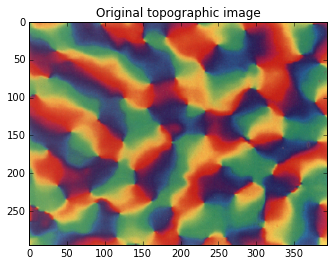

In [2]:
# Orientation preference map: for now, use k-means on Blasdel image
rgb_img = mpimg.imread('v1-topology-blasdel-figure6.png')

plt.figure()
plt.imshow(rgb_img)
plt.title('Original topographic image')

lab_img = color.rgb2lab(rgb_img) # convert to L*a*b* colourspace

ab = lab_img[:,:,1:]
n_rows = np.shape(ab)[0]
n_cols = np.shape(ab)[1]

ab = np.reshape(ab, (n_rows*n_cols, 2))
n_colours = 6

centroids, labels = kmeans2(ab, n_colours, iter=3)

labels = np.reshape(labels, (n_rows, n_cols))

rgb_labels = np.tile(labels[:,:,None], [1,1,3])

OP_range = np.linspace(0, 180, n_colours)
full_OP_map = np.copy(labels)

for i in range(n_colours):
    seg_img = np.copy(rgb_img)
    seg_img[rgb_labels != i] = 0  
    
    # assign an orientation preference (degrees) based on segmentation
    full_OP_map[full_OP_map == i] = OP_range[i]

In [29]:
N_pairs = 75 # no. of E/I pairs to a side of a grid
field_size = 16. # size of field to a side (degrees)
dx = field_size / N_pairs

# xy_range = np.linspace(0, field_size, N_pairs)
xy_range = np.linspace(-field_size/2, field_size/2, N_pairs)

xv, yv = np.meshgrid(xy_range, xy_range) # x and y grid values (degrees)

# sample the OP map uniformly 
min_dim = np.min(np.shape(full_OP_map))
o_samples = np.round(np.linspace(0, min_dim-1, N_pairs))

xo, yo = np.meshgrid(o_samples, o_samples)

xo = xo.astype(int)
yo = yo.astype(int)

OP_map = full_OP_map[xo,yo]

In [41]:
def diff(x,y):
    return np.abs(np.mod(x-y+90,180) - 90)

def G(x,y,sigma):
    return np.exp(-1*diff(x,y)**2/(2*sigma**2))

def get_stim_size(x, size, sigma):
    return (1.+np.exp(-(x + size/2.)/sigma) )**-1. * (1. - (1.+np.exp(-(x - size/2.)/sigma))**-1. )

def generate_ext_stimulus( pref_ori, stim_size, centre, sigma, full_frame=False):
    G_FF = G(pref_ori, OP_map, 32)
    
    if full_frame == False:
        x_dist = np.abs(xv - centre[0])
        y_dist = np.abs(yv - centre[1])
        dist = np.sqrt(x_dist**2 + y_dist**2)
        s_l = get_stim_size(dist, stim_size, sigma)
        
#         s_l = np.ones(dist.shape)
#         s_l[dist > stim_size] = 0
        
        h = s_l*G_FF
        
        h = np.multiply(s_l, G_FF)
        
        plt.figure()
        plt.imshow(s_l)
        plt.title('Stimulus Shape s_l')
        plt.colorbar()
        
    else:
        h = G_FF    
        
    return h

<matplotlib.colorbar.Colorbar instance at 0x10bdd5ea8>

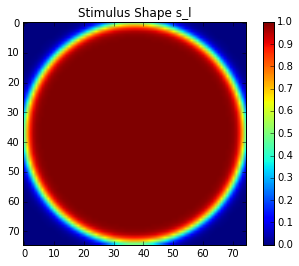

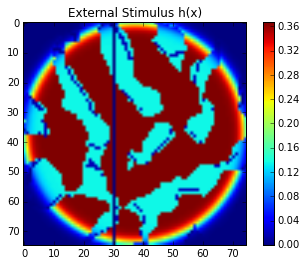

In [45]:
# Parameters:
sig_RF = 16./75
sig_FF = 32
pref_ori = 10
stim_size = 16 # stim radius in degrees
centre = (0,0)

hx = generate_ext_stimulus( pref_ori, stim_size, centre, sig_RF)
plt.figure()
plt.imshow(hx)
plt.title('External Stimulus h(x)')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x106d1be18>

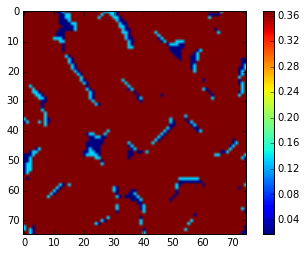

In [18]:
# other plots:
G_FF = G(pref_ori, OP_map, sig_FF)

plt.figure()
plt.imshow(G_FF)
plt.colorbar()